In [1]:
!ls /kaggle/input/clouds-photos/clouds_train

'cirriform clouds'     'cumulus clouds'		 'stratocumulus clouds'
'clear sky'	       'high cumuliform clouds'
'cumulonimbus clouds'  'stratiform clouds'


In [2]:
COUNT = 1000
TRAIN = '/kaggle/input/clouds-photos/clouds_train'
TEST = '/kaggle/input/clouds-photos/clouds_test'

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 185MB/s]


In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') }
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 103 rows of high cumuliform clouds  in 0:00:12.696722
encoded 120 rows of cumulus clouds  in 0:00:14.111229
encoded 77 rows of cirriform clouds  in 0:00:09.071686
encoded 40 rows of stratiform clouds  in 0:00:04.864095
encoded 71 rows of stratocumulus clouds  in 0:00:09.176710
encoded 11 rows of cumulonimbus clouds  in 0:00:01.342424
encoded 64 rows of clear sky  in 0:00:08.023597
encoded 133 rows of high cumuliform clouds  in 0:00:16.490193
encoded 91 rows of cumulus clouds  in 0:00:10.463875
encoded 66 rows of cirriform clouds  in 0:00:07.714908
encoded 49 rows of stratiform clouds  in 0:00:05.713595
encoded 61 rows of stratocumulus clouds  in 0:00:06.995972
encoded 14 rows of cumulonimbus clouds  in 0:00:01.613724
encoded 60 rows of clear sky  in 0:00:07.026253
done in 0:01:55.382902


In [5]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,high cumuliform clouds,cumulus clouds,cirriform clouds,stratocumulus clouds,clear sky,stratiform clouds,cumulonimbus clouds
proportion,0.280591,0.191983,0.139241,0.128692,0.126582,0.103376,0.029536


In [6]:
test_df['tag'].value_counts(normalize=True).to_frame().T

tag,cumulus clouds,high cumuliform clouds,cirriform clouds,stratocumulus clouds,clear sky,stratiform clouds,cumulonimbus clouds
proportion,0.246914,0.211934,0.158436,0.146091,0.131687,0.082305,0.022634


In [7]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 474 samples in 0.003s...
[t-SNE] Computed neighbors for 474 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 474 / 474
[t-SNE] Mean sigma: 2.385751
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.129604
[t-SNE] KL divergence after 1000 iterations: 0.743803
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 486 samples in 0.003s...
[t-SNE] Computed neighbors for 486 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 486 / 486
[t-SNE] Mean sigma: 2.334790
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.012032
[t-SNE] KL divergence after 1000 iterations: 0.780406


In [8]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: clouds', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=6, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=2000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 510 iterations
accuracy: 0.9115
f1: 0.9118
                        precision    recall  f1-score   support

      cirriform clouds       0.86      0.97      0.91        77
             clear sky       1.00      0.94      0.97        64
   cumulonimbus clouds       0.80      0.73      0.76        11
        cumulus clouds       0.96      0.93      0.95       120
high cumuliform clouds       0.92      0.88      0.90       103
     stratiform clouds       0.93      0.93      0.93        40
  stratocumulus clouds       0.82      0.85      0.83        71

              accuracy                           0.91       486
             macro avg       0.90      0.89      0.89       486
          weighted avg       0.91      0.91      0.91       486



<Axes: xlabel='probability', ylabel='Count'>

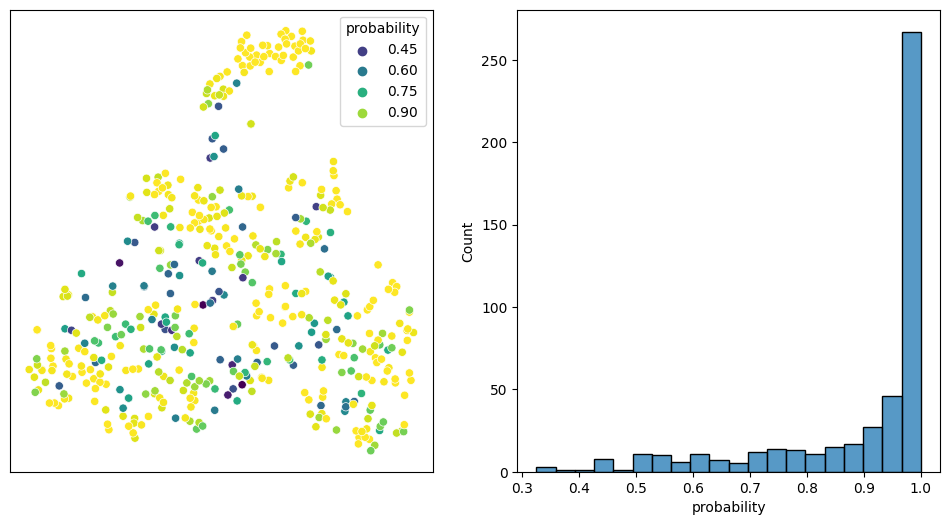

In [10]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)